In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import plotly
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout, ReLU, Embedding
from keras.activations import sigmoid, relu
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.models import Sequential

sns.set()

In [133]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

### Ok, we now ready for start! Here we go @fabriziorom

In [27]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])

In [28]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


In [21]:
def print_nunique_nnan(dataset, columns):
  for column in columns:
    print(column + ":")
    print(len(dataset[column].unique()))
    print(len(dataset[column][dataset[column].isna() == True]))

columns = ['date', 'street_id', 'build_tech', 'floor', 'rooms', 'balcon',
           'g_lift',
           'n_photos',
           'kw1']

print_nunique_nnan(dataset = prices_dataset, columns = columns)

date:
18
0
street_id:
672
0
build_tech:
4
29735
floor:
25
0
rooms:
6
0
balcon:
3
0
g_lift:
3
29992
n_photos:
12
0
kw1:
2
0


### Not so a lot information right now. Let's dive into deeper analysis.

In [ ]:
prices_dataset['date'] = prices_dataset['date'].astype('str')

prices_dataset['date'] = pd.to_datetime(prices_dataset['date'], format = '%Y-%m').dt.strftime("%Y-%m")
# prices_dataset.head()

### Let's try to build histplot showing the dates-prices distribution.

In [ ]:
prices_dataset['price']

In [97]:
def plot_distribution(ylim, hue):
  figure = plt.figure(figsize = (10, 5))

  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-1,1))
  plt.gca().xaxis.set_major_formatter(formatter)

  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'])
  plt.title(f'Price-{hue} distribution for prices')
  plt.ylim([0, ylim])

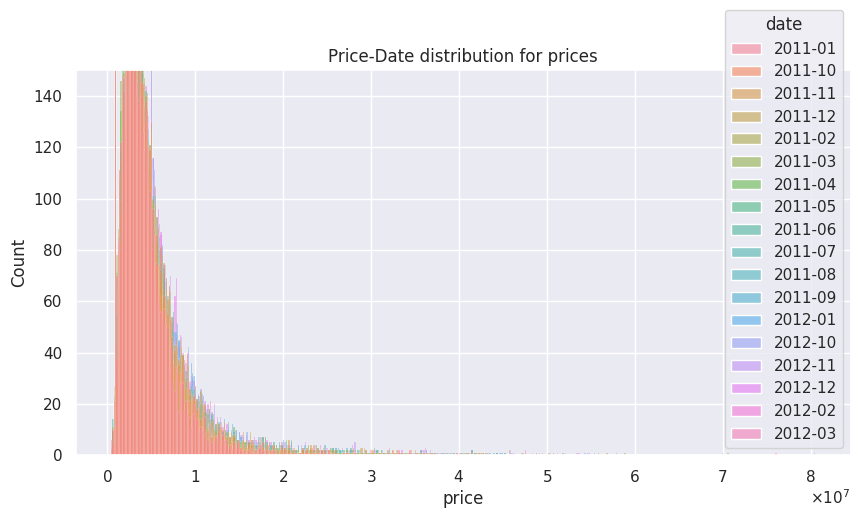

In [41]:
plot_distribution(150, 'date')

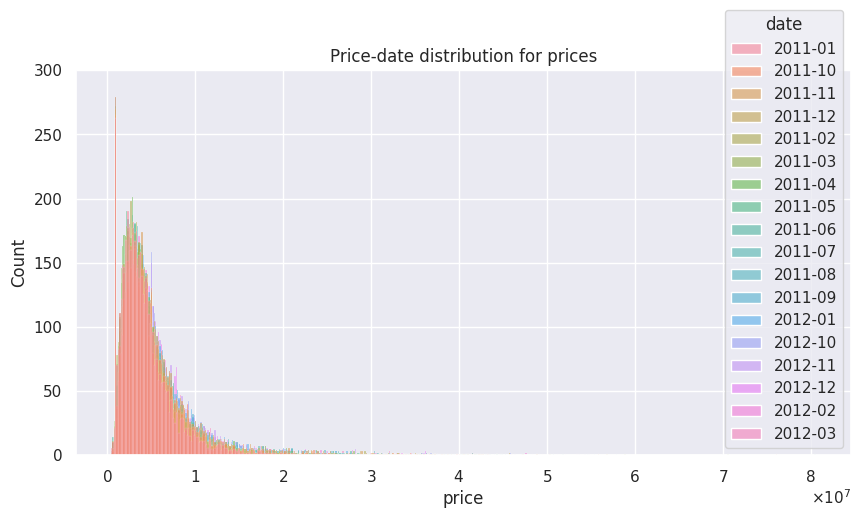

In [44]:
plot_distribution(300, 'date')

### So, looks like to be similar distributions right there. We may notice that old and fresh flats could be both expensive and cheap. But let's try to divide the whole period and take the half.

In [168]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])
prices_dataset['date'] = pd.to_datetime(prices_dataset['date'])
all_dates = prices_dataset['date']

print(f'Max date is {all_dates.max()}')
print(f'Min date is {all_dates.min()}')
print(f'Median date is {all_dates.median()}')

Max date is 2012-12-01 00:00:00
Min date is 2011-01-01 00:00:00
Median date is 2011-09-01 00:00:00


In [169]:
before_median_date = prices_dataset[prices_dataset['date'] < all_dates.median()]
after_median_date = prices_dataset[prices_dataset['date'] >= all_dates.median()]

prices_dataset['flag_before_after'] = prices_dataset['date'] >= all_dates.median()
# prices_dataset.head()

In [170]:
prices_dataset['flag_before_after'] = prices_dataset['flag_before_after'].astype(int)

### And Let's look for the distribution:

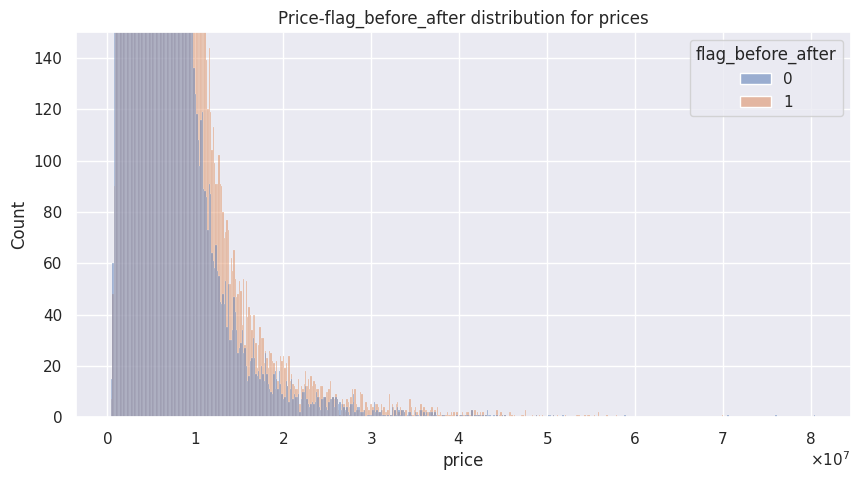

In [74]:
plot_distribution(ylim = 150, hue = 'flag_before_after')

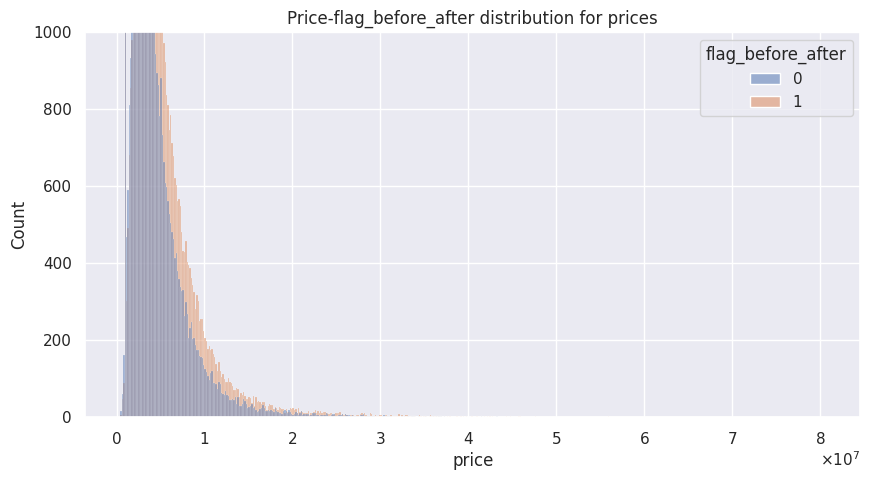

In [77]:
plot_distribution(ylim = 1000, hue = 'flag_before_after')

### So, the difference is shown btw. I wanna try 3 periods.

In [171]:
max_date = prices_dataset['date'].max()
min_date = prices_dataset['date'].min()

median_date = prices_dataset['date'].median()

first_midpoint = min_date + (median_date - min_date) / 2

second_midpoint = median_date + (max_date - median_date) / 2


def three_periods_divison(date, first_midpoint, second_midpoint):
  if date < first_midpoint:
    return 1
  elif first_midpoint <= date < second_midpoint:
    return 2
  else:
    return 3

prices_dataset['three_periods'] = prices_dataset['date'].apply(three_periods_divison,
                                                               args = (first_midpoint,
                                                                       second_midpoint))

print(f"Max date is: {max_date}")
print(f"Мin date is: {min_date}")
print("First mid point:")
print(first_midpoint)
print("Second mid point:")
print(second_midpoint)

Max date is: 2012-12-01 00:00:00
Мin date is: 2011-01-01 00:00:00
First mid point:
2011-05-02 12:00:00
Second mid point:
2012-04-16 12:00:00


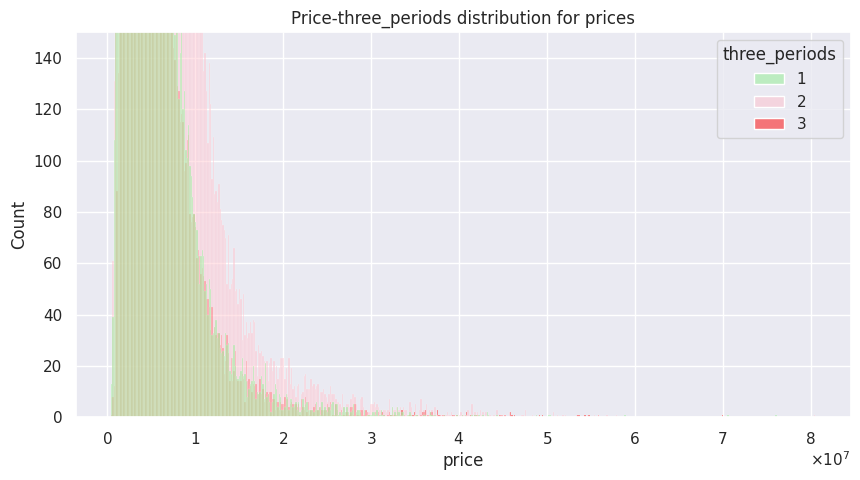

In [98]:
plot_distribution(ylim = 150, hue = 'three_periods')

### So, I assume the double date division to be solid. So, probably, I'll convert date feature to True/False depending on the before/after mid_date. Go on!

### Let's have a view on the street_id feature:

In [172]:
street_id = prices_dataset['street_id']

In [173]:
street_id.nunique()

672

#### So, we have 672 unique street with having no idea about it's qualities and price impact. But in real life of coure street for example in the center increases the flat's price. I wanna try to test hypothesis and sort by street_id.

In [174]:
prices_dataset = prices_dataset.sort_values(by=['street_id'], ascending = True)

In [175]:
median_street_id = prices_dataset['street_id'].median()
median_street_id

334.0

In [176]:
prices_dataset['street_id_flag'] = prices_dataset['street_id'] > median_street_id
prices_dataset['street_id_flag'] = prices_dataset['street_id_flag'].astype(int)

<ipython-input-97-2f84608c91d3>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'])


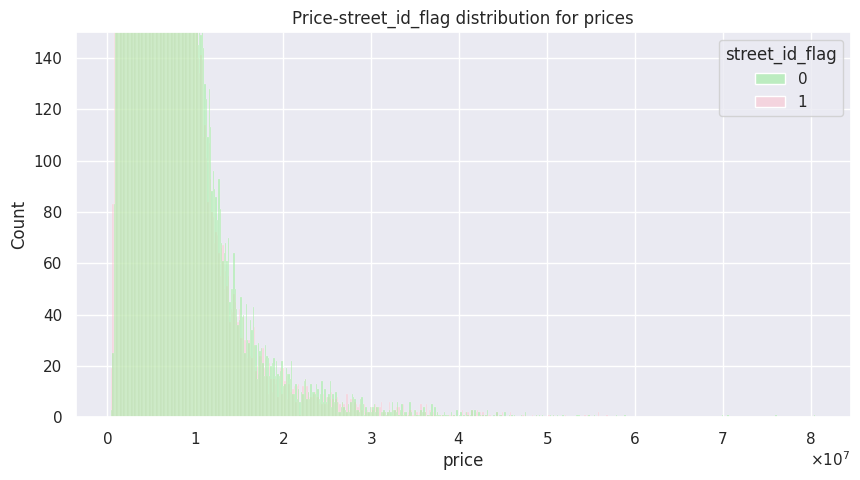

In [177]:
plot_distribution(ylim=150, hue='street_id_flag')

### No, this is garbage research. But what if we try to calculate the mean for each street_id and make the analysis:

In [184]:
def calculate_means_stddev():
  mean_array = {}
  std_dev_array = {}
  for street_id in prices_dataset['street_id'].unique():
      prices = prices_dataset[prices_dataset['street_id'] == street_id]['price']
      mean_array.update({street_id : prices.mean()})
      std_dev_array.update({street_id : prices.std()})
      # break
  return mean_array, std_dev_array

mean_stddev = calculate_means_stddev()

In [189]:
type(mean_stddev[0])

dict

In [187]:
len(mean_stddev[0]), len(mean_stddev[1])

(672, 672)

In [192]:
max(mean_stddev[0].values()), min(mean_stddev[0].values())

(19440871.21212121, 1253658.9147286823)

In [195]:
type(mean_stddev[0].values())

dict_values

### We may see that some street_id has great average flat cost than others. Distribution of means will show us this:

<ipython-input-197-9ecce464b1b5>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)


Text(0.5, 1.0, "Mean ID cost's distribution")

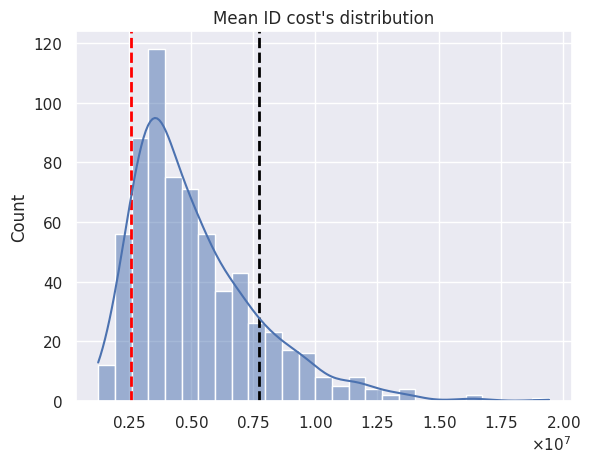

In [197]:
plt.gca().xaxis.set_major_formatter(formatter)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.1), color = 'red', linestyle = 'dashed',
            linewidth = 2)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.85), color = 'black', linestyle = 'dashed',
            linewidth = 2)
sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)

plt.title("Mean ID cost's distribution")

### As we see, some street_id's are expensive and some not. But if we'll try to One-hot encode this feature we'll get extra 672 features. That's much. I'll try to divide the street on groups.

### I gonna try to make 3 street_id ranges:
1. Expensive streets => less than 10% quantile.
2. Middle streets => greater than 10% but less than 76% quantile.
3. Cheap streets => greater than 76% quantile.

### Let's decode this logic:

In [201]:
len(list(mean_stddev[0].values()))

672

In [205]:
def create_street_groups(dict_):
  array = list(dict_.values())
  groups_street_id = {}
  for i in range(len(array)):
    if array[i] < np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 1
    elif np.quantile(array, 0.85) > array[i] >= np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 2
    else:
      groups_street_id[list(dict_.keys())[i]] = 3
  return groups_street_id

group_distribution = create_street_groups(mean_stddev[0])

In [206]:
len(group_distribution)

672

In [208]:
prices_dataset = prices_dataset.drop(columns = ['street_id_flag'])

In [209]:
prices_dataset['street_group'] = prices_dataset['street_id'].map(group_distribution)

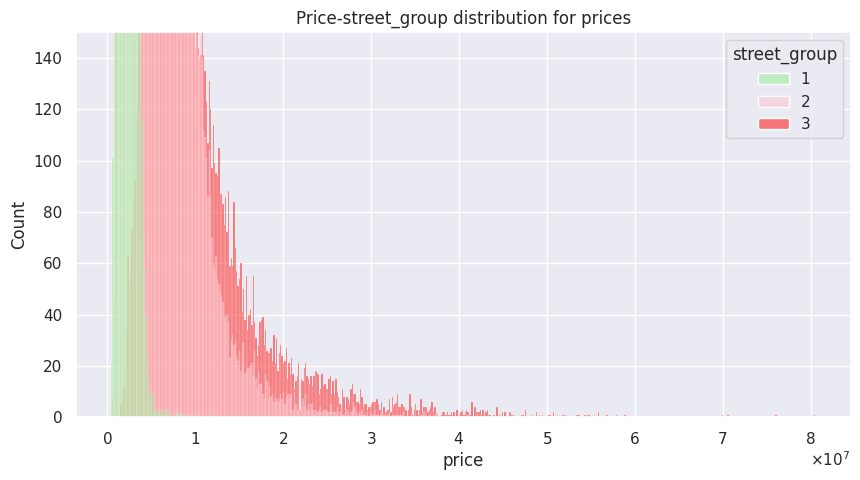

In [211]:
plot_distribution(150, hue = 'street_group')

### Awesome: I got what I needed! Save & continue tomorrow!

In [212]:
prices_dataset.to_csv('first_update_predict_prices.csv')